In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['figure.autolayout'] = True
plt.rc('font', size=16)
plt.rc('font', family='serif')

**Objetivos**:


*   Implementar um sistema de sonar.
*   Implementação prática de filtros não causais.
*   Retomar contato com o princípio de distância mínima, também conhecido como o método de quadrados mínimos de álgebra linear.
*   Retomar contato com correlação de sinais, que é relacionado com o produto interno de álgebra linear.
*   Primeiros princípios de filtros casados.

Vamos inicialmente relembrar o conceito de invariância no tempo, que será bastante usado nesse experimento. Imagine que um sinal $r[n]$ é filtrado por um filtro com resposta ao impulso $h[n]$, produzindo uma resposta $y[n]$. Imagine agora uma outra situação, em que o mesmo sinal é aplicado ao mesmo filtro, mas depois de algum tempo dado por $d$ amostras. Nesse segundo caso, a entrada do filtro é $r[n-d]$. O princípio de invariância no tempo garante que a saída é o mesmo sinal $y[n]$, mas atrasado de $d$ amostras. Ou seja, nesse segundo caso a resposta é $y[n-d]$.

O mesmo princípio também se aplica em relação à resposta ao impulso. Ou seja, se o sinal $r[n]$ é aplicado a um filtro com resposta ao impulso $h[n-d]$, a saída também será dada por $y[n-d]$. A invariância no tempo para sistemas a tempo contínuo tem uma definição análoga.

Uma aplicação importante desse princípio é em sistemas de sonar, usados para detectar a distância de um objeto. Um sonar emite um sinal acústico $s(t)$ e fica medindo o sinal acústico ambiente $r(t)$. Se em algum momento ele detecta um eco de $s(t)$, ele avisa que há um objeto à frente. Calculando o tempo entre a transmissão de $s(t)$ e a recepção do eco, e sabendo a velocidade do som, é possível calcular a distância até o alvo. Para esses cálculos, em geral usando que a velocidade do som no ar é de cerca de 340 m/s e, na água, cerca de 1500 m/s.

A ideia de usar ecos de sinais acústicos para determinar características do ambiente é usado por submarinos, navios, baleias, morcegos, etc. Princípios semelhantes também são usados em sistemas de ultrassom (como em aplicações médicas e em detectores de distância do Arduino), sísmica (para encontrar reservatórios de petróleo) e radares.

O problema aqui é como olhar para um sinal medido, $r(t)$, e decidir qual trecho dele contém um eco de $s(t)$. Isso pode ser particularmente difícil quando o eco possui uma amplitude baixa em relação ao ruído ambiente, como vemos na situação abaixo. Aqui, $s(t)$ é uma senóide de 20,3Hz com duração de um segundo e modelamos o sinal recebido como $r(t) = s(t - 1.67) + w(t)$, em que $w(t)$ representa o ruído. Ou seja, o eco levou 1,67 segundos para retornar. 

<font color='red'>Pergunta: Se o sinal $r(t)= s(t - 1.67) + w(t)$ representa um sistema de sonar aquático, isso significa que o alvo está a que distância do sonar?</font>

d = vt = 1500 * (1,67/2) = 1252,5 m

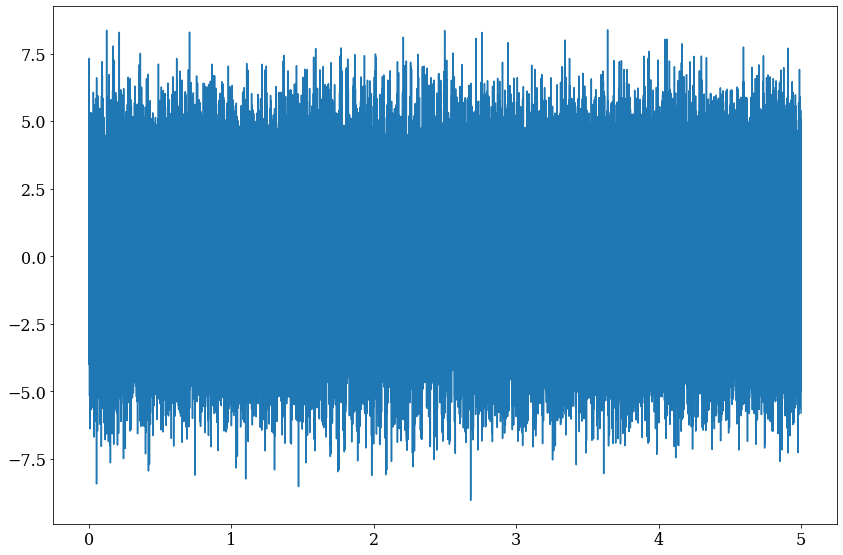

In [ ]:
fs = 48000
Tsa = 1/fs
Tr = 5 #Duração do sinal recebido
Nr = int(Tr*fs) #Número de amostras do sinal recebido
Ts = .9 #Duração de s(t)
ts = np.arange(0,int(Ts*fs))*Tsa

s = np.cos(2*np.pi*20.3*ts)
r = 2*np.random.randn(Nr)  #Inicialmente, fazemos r(t) = n(t)

Atraso = 1.67
D_a = int(Atraso * fs)   #Numero de amostras do atraso
r[D_a:D_a+s.size] += s    #Aqui somamos o eco ao ruído, dando uma baixa amplitude para o eco

t = np.arange(0,Nr)*Tsa
plt.plot(t,r);

Visualmente, olhando apenas para $r(t)$ não é possível idenfiticar onde começa o eco. Para resolver esse problema, vamos usar o critério de *distância mínima*, que liga álgebra linear com uma série de aplicações que vão desde processamento de sinais até inteligência artificial, passando por telecomunicações, sonares, radares, regressão linear, tomografia, sensoriamento remoto, etc. Em muitas aplicações o princípio de distância mínima é conhecido como o método dos quadrados mínimos.

Para facilitar a notação, vamos trabalhar só a tempo discreto, lembrando que a amostra $n$ corresponde ao instante de tempo $n T_s$. E para deixar clara a linguagem que vamos usar, lembre que a distância entre dois vetores é dada por

$$\|r[n] - y[n]\| ^2 = \sum_{n=0}^{N-1} |r[n] - y[n]|^2.$$

Ou seja, a distância é igual à energia da diferença. Observe que aqui estamos falando da distância entre dois sinais, $r[n]$ e $y[n]$. Isso não é a mesma coisa que a distância entre o sonar e o alvo.

Imagine, então, que o eco começou a ser recebido em um instante $D_a$, ou seja, $r[n] = s[n - D_a] + w[n]$. Obviamente, não sabemos o valor de $D_a$, já que nosso objetivo é justamente determinar esse instante. Vamos então dar um chute, dizendo que o eco começou a ser recebido no instante $d_\text{chute}$. Ou seja, vamos chutar que o sinal recebido é dado por $s[n-d_\text{chute}]$. Vamos então calcular a distância entre o sinal recebido, $r[n]$, e o nosso chute, $s[n-d_\text{chute}]$, dada por $\|r[n] - s[n-d_\text{chute}\|^2$.

Aqui podem acontecer duas coisas. 

1.   Por acaso, o chute pode estar certo. Nesse caso, $d_\text{chute} = D_a$ e $r[n]- s[n-d_\text{chute}] = w[n]$. Ou seja, a distância entre os dois sinais vai ser igual à energia do ruído. 
2.  O chute pode estar errado. Nesse caso, a distância entre os sinais vai ser igual à energia do sinal  $r[n]- s[n-d_\text{chute}] = s[n - D_a] - s[n-d_\text{chute}] + w[n]$. Ou seja, a distância calculada vai ser igual à energia do ruído mais um outro sinal.

O critério de distância mínima parte do princípio que a energia no segundo caso tende a ser maior do que a energia no primeiro caso. A validade desse princípio é ilustrada na figura abaixo, onde mostramos os sinais $r[n] - s[n-D_a]$, que é o valor correto do atraso, e $r[n] - s[n-1000]$.

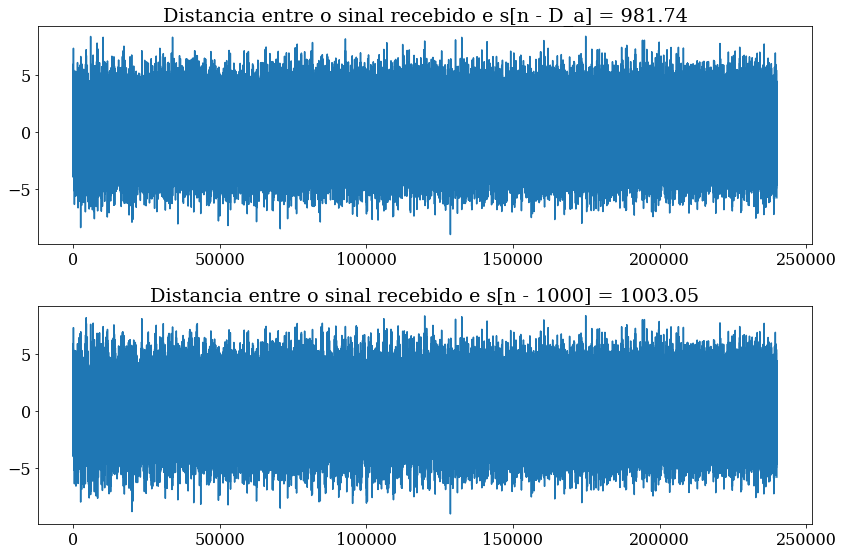

In [ ]:
diferenca = np.copy(r)
diferenca[D_a:D_a+s.size] -= s

plt.subplot(2,1,1)
plt.plot(diferenca);
plt.title('Distancia entre o sinal recebido e s[n - D_a] = ' + '%.2f' %np.linalg.norm(diferenca));

diferenca = np.copy(r)
diferenca[1000:1000+s.size] -= s

plt.subplot(2,1,2)
plt.plot(diferenca);
plt.title('Distancia entre o sinal recebido e s[n - 1000] = ' + '%.2f' %np.linalg.norm(diferenca));

Após algumas contas que serão mostradas no final desse roteiro, não é muito difícil de ver que, para achar o atraso que dá a menor distância, basta procurar o atraso que resulta na maior correlação entre o sinal recebido e o eco atrasado. Ou seja

$$\arg\min_d \|r[n] - s[n - d]\|^2 = \arg\max_d \sum_{n = 0}^{N_r-1} r[n] s[n-d].$$

A soma no lado direito dá a correlação entre o sinal recebido e o eco atrasado. Não é uma coincidência que essa fórmula também é igual ao produto interno entre o sinal recebido e o eco atrasado; o princípio de distância mínima tem muita relação com álgebra linear, e é, na verdade, uma de suas principais aplicações. Não vamos precisar de mais detalhes sobre a correlação neste experimento, mas se você quiser se aprofundar, pode começar pela [Wikipedia](https://pt.wikipedia.org/wiki/Correla%C3%A7%C3%A3o).

Após mais algumas contas que também serão mostradas no final desse roteiro, é possível mostrar que essa soma é igual à amostra $d$ da saída de um filtro cuja entrada é $r[n]$ e cuja resposta ao impulso é $s[-n]$. Esse filtro é conhecido como o *filtro casado* com o sinal $s[n]$. Em resumo, a *convolução* entre $r[n]$ e $s[-n]$ é igual á *correlação* entre $r[n]$ e $s[n]$.

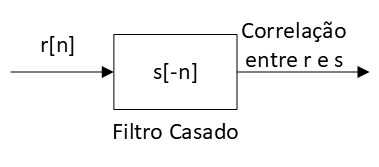

Um problema aqui é que o filtro com resposta ao impulso $s[-n]$ não é causal. Esse problema é o mesmo de um filtro passa baixas ideal, cuja resposta ao impulso é um sinc, que também não é causal. Esse é um dos fatores que fazem com que o filtro ideal não possa ser implementável na prática. (Outro fator importante é o fato de que a resposta ao impulso é infinita.) Por outro lado, vimos no experimento anterior que existem implementações práticas de um filtro passa baixas. Observe abaixo sua resposta ao impulso, que é aproximadamente um sinc atrasado.

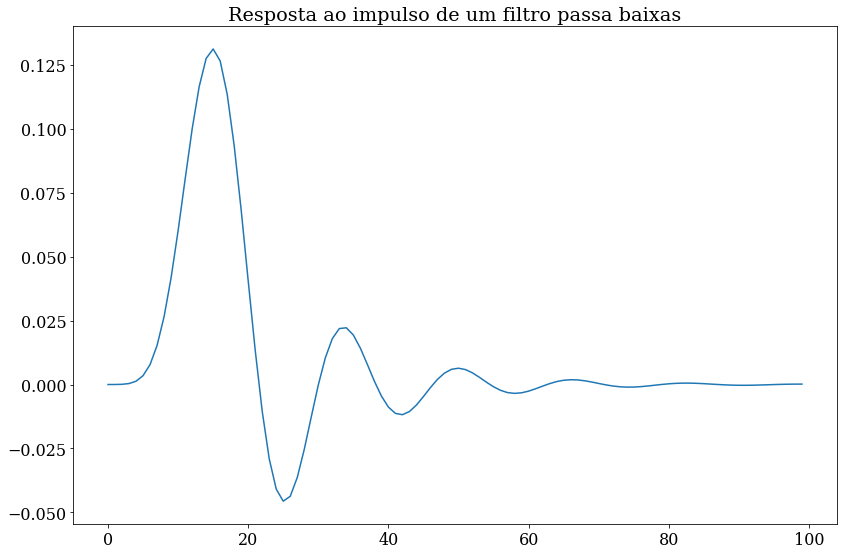

In [ ]:
from scipy import signal

#Projeta o filtro
sos = signal.butter(8, 3000, 'low', fs = fs, output = 'sos')

#Plota a resposta ao impulso do filtro
plt.plot(signal.sosfilt(sos, signal.unit_impulse(100)));
plt.title('Resposta ao impulso de um filtro passa baixas');

Use o comando `np.flipud` para gerar a resposta ao impulso do filtro casado causal. Esse comando inverte a ordem dos elementos do vetor original. Vamos chamar essa resposta ao impulso causal de $h[n]$.  **Responda as seguintes perguntas**:

1. Qual a diferença entre a resposta ao impulso dada pelo comando `np.flipud` e $s[-n]$?

2. Lembrando do princípio de invariância no tempo, qual a relação entre a saída do filtro casado ideal e a saída do filtro cuja resposta ao impulso é $h[n]$?

Use agora o comando `np.convolve` para filtrar o sinal $r[n]$ com o filtro casado. **Plote o resultado**. Use o comando `np.argmax` para determinar a amostra com a maior correlação na saída do filtro casado causal $h[n]$.

<font color='red'>**Responda** Lembre que o maior valor na saída do filtro casado está relacionada à menor distância. Quando observamos um pico no instante $\hat{d}$ na saída do filtro casado causal, em que instante o eco começou a ser recebido?</font>

1. A diferença é um deslocamento
2. Invariância no tempo -> o sinal de entrada deslocado gera uma saída idêntica, mas deslocada

123354

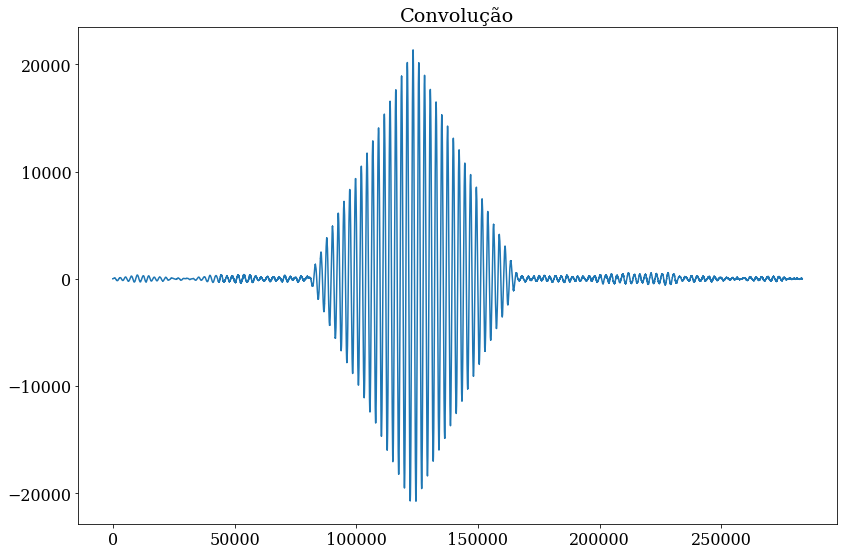

In [ ]:
h = np.flipud(s) # resposta ao impulso causal
conv = np.convolve(r,h) #convolução de r[n] e h[n] = correlação de r[n] e s[n]

plt.plot(conv)
plt.title('Convolução')

np.argmax(conv) #amostra com a maior correlação na saída do filtro casado causal h[n] = dist mínima

Usando o comando `plt.xlim`, dê um zoom de cem amostras em torno do máximo e observe que não é nada fácil encontrar o valor preciso do instante em que o máximo ocorre, já que o valor da correlação varia muito pouco nas amostras próximas. Um pequeno ruído pode levar a um erro de muitas amostras na determinação do início do eco. 

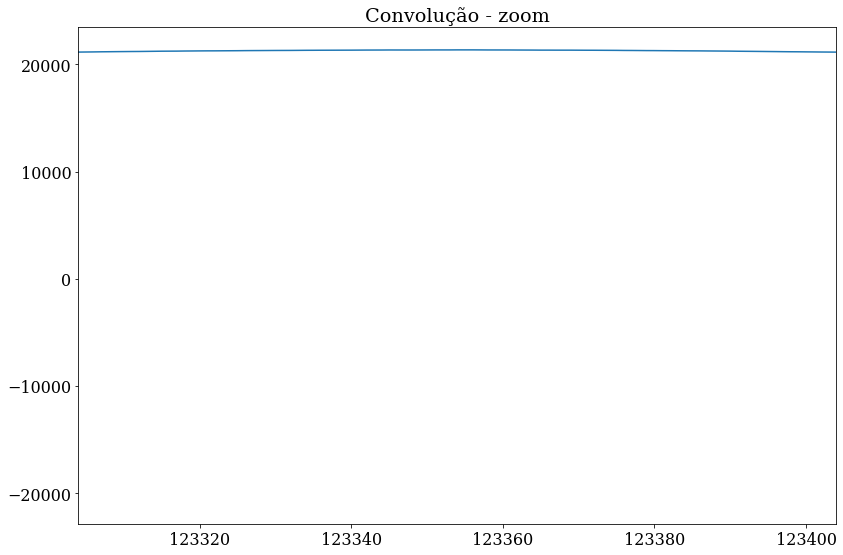

In [ ]:
plt.plot(conv)
plt.title('Convolução - zoom')
plt.xlim(np.argmax(conv)-50, np.argmax(conv)+50);

Observe também que a saída do filtro casado tem uma duração muito grande, dificultando ainda mais a determinação do seu valor máximo. Pior, isso dificulta a detecção de dois alvos separados por uma distância pequena. **Para ver isso, repita o experimento acima, mas coloque agora dois ecos, um com atraso D_a, outro com atraso D_a + 10.** Nesse caso, gostaríamos de observar dois picos na saída do filtro casado, um para cada alvo. O que observamos na realidade?

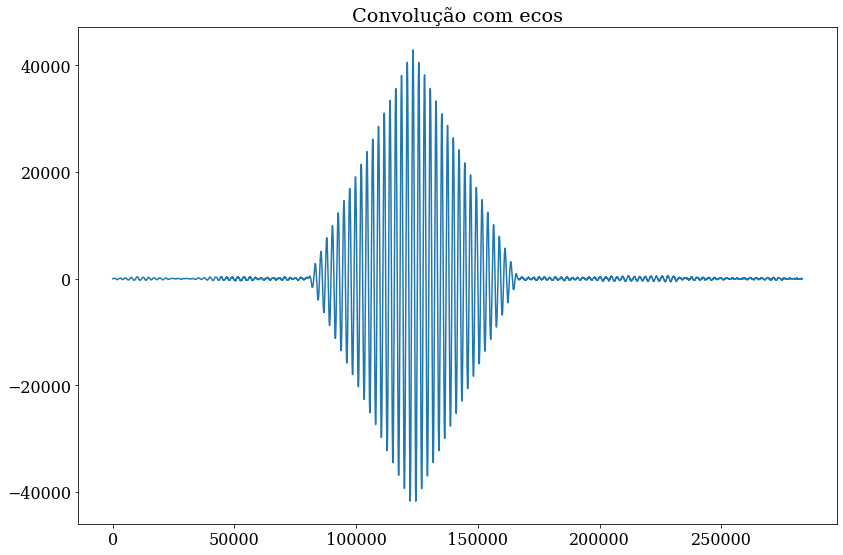

In [ ]:
D_a = int(Atraso * fs) ;

r[D_a+10:D_a+10+s.size] += s

conv_ecos = np.convolve(r,h)

plt.plot(conv_ecos);
plt.title('Convolução com ecos');


Para solucionar esses problemas, vamos pensar primeiramente em termos teóricos. Seja $p[n]$ o resultado de filtrar o próprio sinal $s[n]$ pelo filtro casado, ou seja, $p[n] = s[n]*s[-n]$. Imagine que não há ruído. Usando a invariância no tempo e a linearidade da convolução, nos dois casos abaixo **escreva** a saída do filtro casado em termos de $p[n]$:

1. Há apenas um eco, que começa a ser recebido após $D_1$ amostras, ou seja, $r[n] = s[n-D_1]$.

2. Há dois ecos com atrasos $D_1$ e $D_2$, ou seja, $r[n] = s[n-D_1] + s[n - D_2]$.

A partir do segundo caso acima, se queremos separar os dois ecos, **responda**:

1. Que forma de onda desejamos para $p[n]$?

2. Que forma de onda relativamente óbvia de $s[n]$ leva ao $p[n]$ desejado?

Infelizmente, essa forma de onda "óbvia" tem um grande problema. Em geral, queremos que $s[n]$ tenha uma energia alta, para poder combater o ruído. Para aumentar a energia de um sinal, podemos aumentar sua amplitude e/ou sua duração. Mas para esse $s[n]$ "óbvio", não temos a opção de aumentar a duração, só a amplitude. Mas é difícil aumentar muito a amplitude na prática, começam a aparecer distorções no sinal, componentes podem queimar, alto-falantes podem começar a "rachar", etc. 

Uma alternativa muito usada na prática é um sinal chamado *chirp*, uma senoide com frequência variável. Para esse sinal, podemos facilmente aumentar sua energia aumentando a sua duração.

Para um sinal $s(t) = \cos(\phi(t))$, sua frequência instantânea em Hz é dada por

$$f(t) = \frac{1}{2\pi}\frac{d}{dt}\phi(t).$$

Para gerar um sonar usando o alto-falante do computador, podemos pensar em usar um pulso com duração de um segundo, com frequência indo de 0 Hz a 20 kHz. Nesse caso, a frequência em cada instante de tempo é dada por $f(t) = 20000 t$, de forma que $s(t) = \cos(20000 \pi t^2)$.

**Crie o sinal chirp $s(t)$ acima e plote o sinal $p(t)$ correspondente. Qual a vantagem de usar esse sinal em relação ao cosseno usado no início desse experimento?**

1. $y[n]=r[n]*s[-n]=s[n-D_1]*s[-n]$ \\
$y[n]=p[n-D_1]$

2. $y[n]=r[n]*s[-n]$ \\
$=(s[n-D_1]+s[n-D_2])*s[-n]$ \\
$=[n-D_1]*s[-n]+[n-D_2]*s[-n]$ \\
$ =p[n-D_1]+p[n-D_2]$

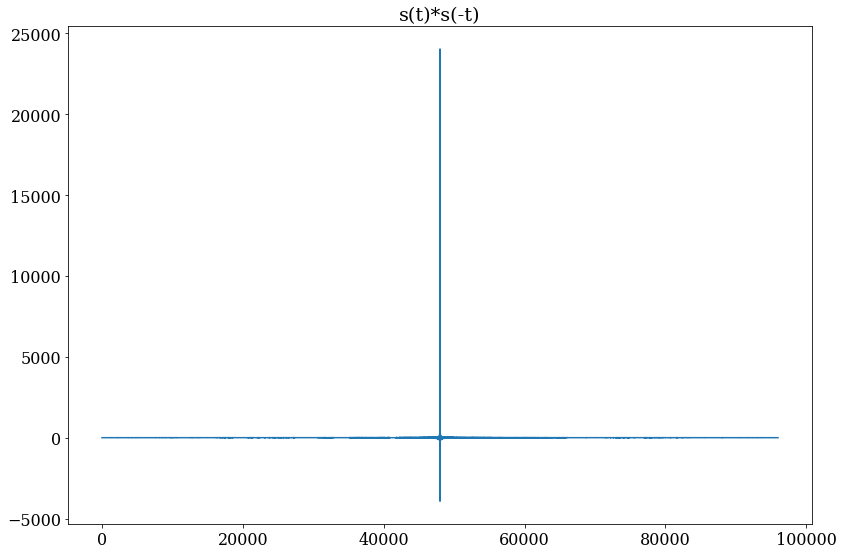

In [ ]:
ts = np.arange(0,int(1*fs))*Tsa
s_chirp = np.cos(20000*np.pi*(ts**2));
p=np.convolve(s_chirp,np.flipud(s_chirp));
plt.plot(p);
plt.title('s(t)*s(-t)');


47999

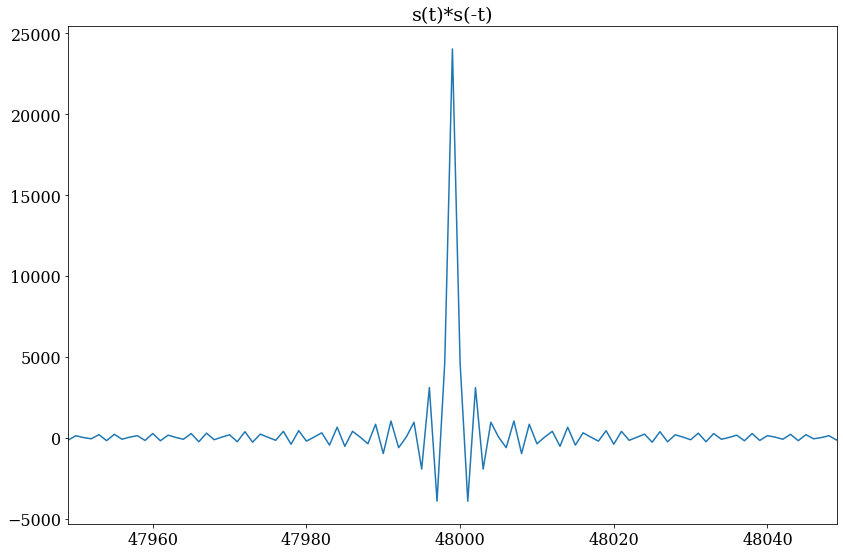

In [ ]:
plt.plot(p)
plt.title('s(t)*s(-t)')
plt.xlim(np.argmax(p)-50, np.argmax(p)+50);
np.argmax(p)

O arquivo fornecido com o roteiro correponde a um experimento usando o chirp  gerado acima. O arquivo foi gerado com o comando `np.save`. Para ler o dado, use o comando `r = np.load("Recebido.npy")`

Passe agora $r[n]$ pelo filtro casado com o chirp e **responda**: A que distância estão os alvos? O experimento foi executado no ar. Não se esqueça de usar `plt.xlim` pois tem mais do que um eco. Você pode também usar o comando `np.where` para determinar quais amostras na saída do filtro são maiores do que um determinado valor. Esse caminho é mais próximo do que é feito na prática, em que a saída do filtro casado é continuamente monitorada e quando ela passa de algum valor um alerta de alvo é disparado. De qualquer  forma, observe como nesse caso conseguimos separar alvos que estão mais próximos do que quando usamos apenas uma senoide.

Duas últimas observações. No sinal fornecido você sabe que existem ecos, e seu papel é procurar onde ele começa. Na prática isso não ocorre, não sabemos se existe ou não um eco. O que se faz é ficar monitorando a saída do filtro casado, e quando ela fica maior que algum limiar é dado um alerta. Observe que se esse limiar for muito alto, corremos o risco de não detectar um alvo quando ele está presente. Por outro lado, se esse valor for muito baixo, corremos o risco de disparar um alarme indevidamente, já que a saída do filtro pode ter sido alta por acaso, devido a uma configuração particular do ruído. Isso é a mesma coisa que as probabilidades de falso positivo e falso negativo nos testes de covid. A determinação dos compromissos envolvidos na escolha do limiar são temas de uma área chamada teoria da detecção. 

Finalmente, esse experimento foi todo sintético, com dados simulados. Isso porque ondas de frequência abaixo de 20kHz (que podem ser transmitidas por alto falantes) são muito absorvidas pelos materiais, não produzem bons ecos. É por isso que sensores de distância de Arduinos usam ultrassom. Estes também possuem frequências mais altas, que permitem separar alvos mais próximos.

72004

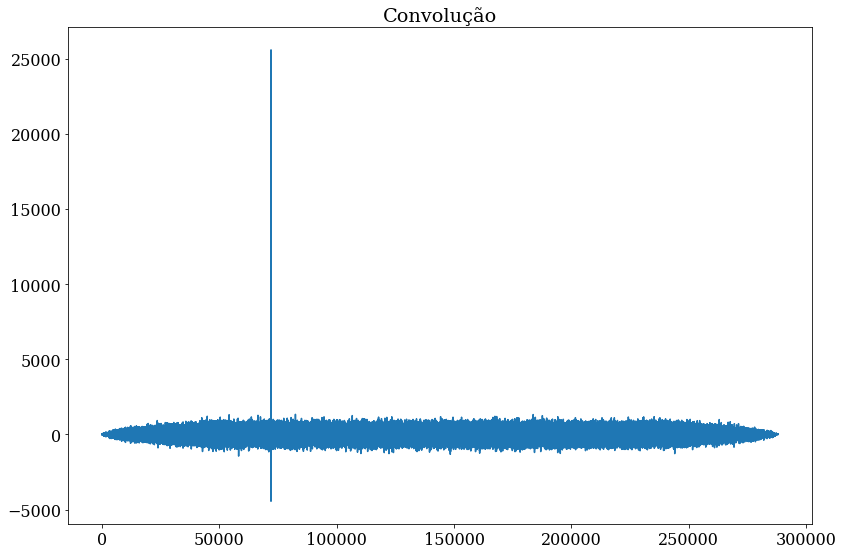

In [ ]:
r = np.load("Recebido.npy")
h = np.flipud(s_chirp) # resposta ao impulso causal
conv = np.convolve(r,h) #convolução de r[n] e h[n] = correlação de r[n] e s[n]

plt.plot(conv)
plt.title('Convolução')
#plt.xlim(np.argmax(conv)-10, np.argmax(conv)+10);

np.argmax(conv) #amostra com a maior correlação na saída do filtro casado causal h[n] = dist mínima

(array([71999, 72004]),)

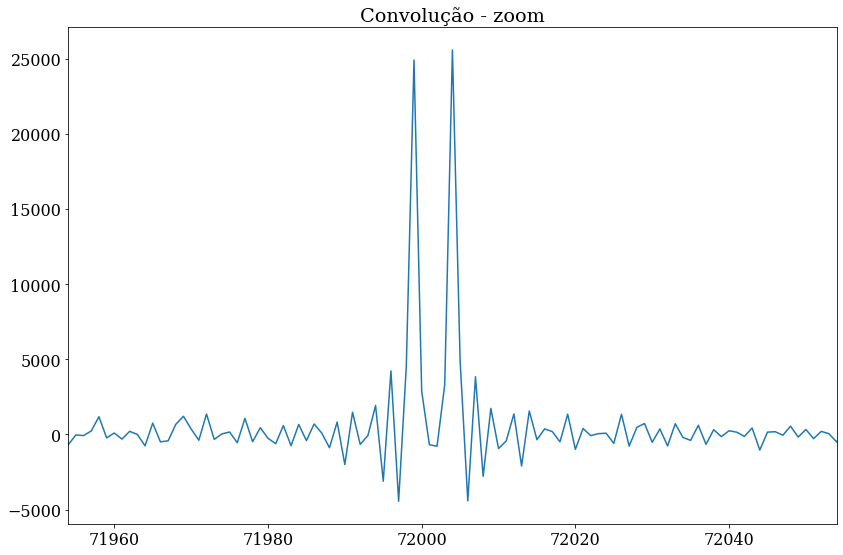

In [ ]:
plt.plot(conv)
plt.title('Convolução - zoom')
plt.xlim(np.argmax(conv)-50, np.argmax(conv)+50);

np.where(conv>15000)

$d = v\cdot t = v_{som-ar}\cdot ((n-D_a)\cdot Tsa)/2$ \\

In [ ]:
n1=71999;
n2=72004;
Atraso=1.67;
D=len(s_chirp);

d_1=340*((n1-D)*Tsa)/2
print("d_1 = "+ str(d_1)+" m")

d_2=340*((n2-D)*Tsa)/2
print("d_2 = "+ str(d_2)+" m")

d_1 = 84.99645833333332 m
d_2 = 85.01416666666667 m


# Indo do critério de distância mínima até o filtro casado

O critério de distância mínima diz que a melhor estimativa que podemos fazer do o atraso do eco, $d$, é encontrando o atraso que dá a menor distância entre o sinal recebido, $r[n]$, e o eco com atraso $d$:

$$\hat{d} = \arg\min_d \|r[n] - s[n - d]\|^2.$$

Mas

$$\|r[n] - s[n - d]\|^2 = \sum_{n = 0}^{N_r-1} (r[n] - s[n-d])^2,$$
onde $N_r$ é o número de amostras de $r[n]$. Expandindo o termo ao quadrado na somatória, temos que

$$\|r[n] - s[n - d]\|^2 = \sum_{n = 0}^{N_r-1} r[n]^2 - 2\sum_{n = 0}^{N_r-1} r[n] s[n-d] + \sum_{n = 0}^{N_r-1} s[n-d]^2.$$

A primeira somatória acima dá a energia do sinal recebido, e não depende de $d$. Da mesma forma, e ignorando efeitos de borda, para qualquer valor de $d$, a última somatória dá a energia de $s[n]$. Ou seja, para encontrar o $d$ que dá a menor distância, é preciso achar o $d$ que dá o maior valor possível para a soma no meio:

$$\hat{d} = \arg\min_d \|r[n] - s[n - d]\|^2 = \arg\max_d \sum_{n = 0}^{N_r-1} r[n] s[n-d].$$

Em resumo, o atraso que minimiza a distância é o mesmo que maximiza a correlação. Imagine agora um filtro cuja resposta ao impulso seja $h[n] = s[-n]$. Sua saída é dada por

$$y[d] = r[d]*h[d] = \sum_{n = -\infty}^\infty r[n] h[d-n].$$

Mas $h[d-n] = s[n-d]$. Assim, 

$$y[d] = \sum_{n = -\infty}^\infty r[n] s[n-d].$$

Assumindo que $r[n]$ e $s[n]$ sejam nulos fora do intervalo de observação, concluímos que 

$$y[d] = \sum_{n = 0}^{N_r-1} r[n] s[n-d].$$

Ou seja, a amostra $d$ do filtro casado dá a correlação entre $r[n]$ e $s[n-d]$.